In [2]:
import pandas as pd
import numpy as np
import itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import loguniform, beta, uniform

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


In this notebook we introduce a general structure for design a ML-oriented project. In short, we will develop the flow depicted in the figure.
![](ml_project_flow.png) 

As raw data collection, we use the 'Titanic' dataset. The dataset is used in one of first competition in Kaggle. The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The dataset contains the details of a subset of the passengers on board (891 to be exact) and importantly, will reveal whether they survived or not, the target of our task.
Data are represented as tabular data, each row is a passenger and each column is a feature describing the passenger.

We load the dataset thorugh the <code>fetch_openml</code> method in SKLearn. In this case, the target column and the feature matrix are alreasy separated.

In [3]:
X, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True) #loading time 5/6 sec
y = y.map({'0':0,'1':1})

Before the training and test splitting, we have to deal with missing value. Specifically, we have to define the strategy to be pply after the splitting if we encounter missing values.

**Hint:** Start the analysis of the missing values by columns, so to identify features that might be removed or subject of imputation techniques.

Which are the most problematic features in terms of missing values?

**Task**: For each column, return the percentage of missing values in it?

In [4]:
X.isnull().sum(axis=0)/X.shape[0]

pclass       0.000000
name         0.000000
sex          0.000000
age          0.200917
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000764
cabin        0.774637
embarked     0.001528
boat         0.628724
body         0.907563
home.dest    0.430863
dtype: float64

An intuitive visualization tool supportin the analysis of missing values - besides Pandas' methods or DataFrame visualization - is the library <code>missingno</code>. In particular, via the <code>matrix</code> method we can plot where the missing values are located in the feature matrix.

In [5]:
X['home.dest'].head(20)

0                        St Louis, MO
1     Montreal, PQ / Chesterville, ON
2     Montreal, PQ / Chesterville, ON
3     Montreal, PQ / Chesterville, ON
4     Montreal, PQ / Chesterville, ON
5                        New York, NY
6                          Hudson, NY
7                         Belfast, NI
8                 Bayside, Queens, NY
9                 Montevideo, Uruguay
10                       New York, NY
11                       New York, NY
12                      Paris, France
13                               None
14                      Hessle, Yorks
15                       New York, NY
16                       Montreal, PQ
17                       Montreal, PQ
18                               None
19                       Winnipeg, MN
Name: home.dest, dtype: object

<Axes: >

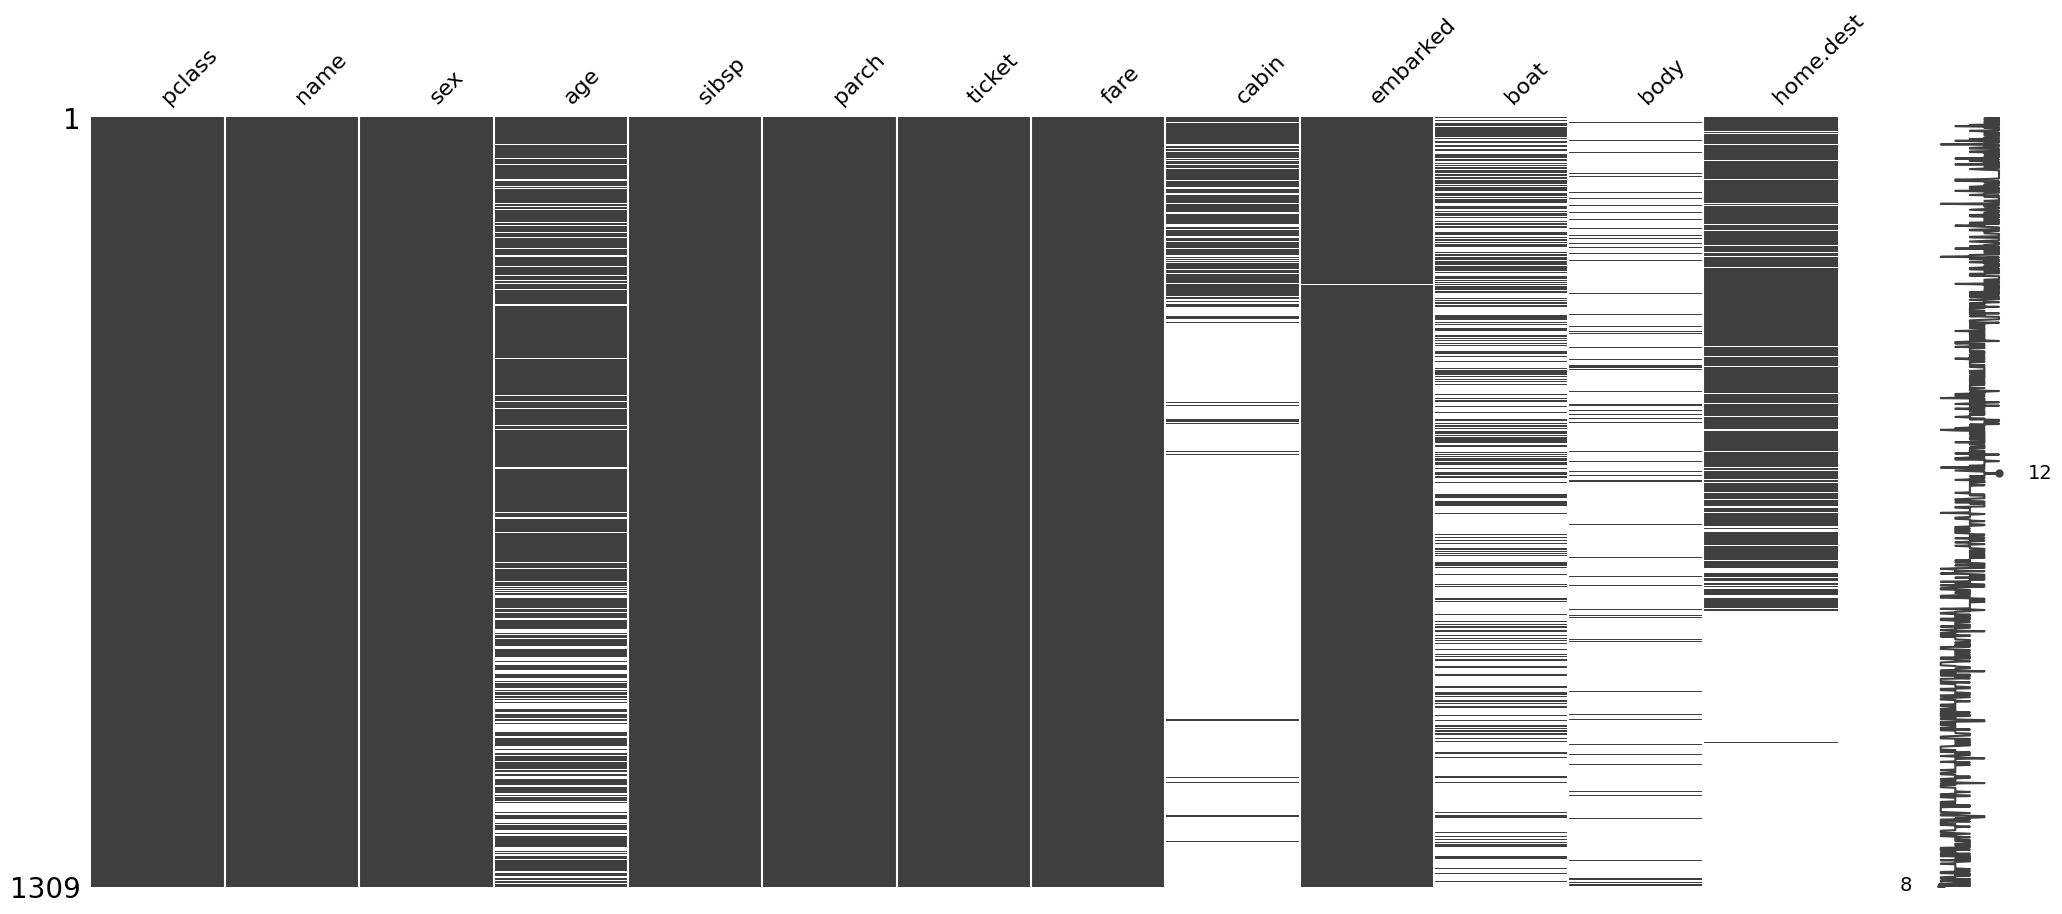

In [6]:
msno.matrix(X)

We have to drop the columns:

- **cabin**: too many missing values;
- **boat**: too many missing values, and missing values are highly correlated with the target label. If the boat is missing it means that the passenger did not take the boat and died (see Di Caprio);
- **home.dest**: too many missing values;
- **body**: too many missing values.

In this case we can act on feature removal when we will define a <code>ColumnTransformer</code>.

## Definition of the Data Transformation Pipeline

Once, we identified the features to discard, we proceed by defining  - **not applying** - the data transformation pipeline, i.e. specifying which transformation must be applied to each feature.

This is a design step, where sketching the transformation pipeline may be useful. 

In our case the transformation pipeline is drawn in the figure:
![](titanic_transformation_pipeline.png)

The columns not reported in the figure will be discarded.

For features _age_ and _fare_ the pipeline is composed by two transformers:
1. <code>KNNImputer</code>: both features contain missing values, so we have to apply an imputation strategy. In this case the strategy is based on the idea of $k$-nearest neighbors. 
2. <code>StandardScaler</code>: both features are numerical

For features _pclass_:
1. An <code>OrdinalEncoder</code> transforms the strings '3','2' and '1' corresponding to the ticket classes into the numerical values 3,2 and 1.

For features _sex_ and _embarked_, we apply:
1. <code>SimpleImputer</code>: feature _embarked_ contains two missing values, while the column _sex_ will be untouched. As a strategy we use <code>'most_frequent'</code> since both features are categorical
2. <code>OneHotEncoder</code>: features are categorical.

For features _sbsp_ and _parch_ we define a customer transformer that builds a new feature *is_alone* indicating whether the passenger travelled alone or not. More details about how to code customer transformers in the following optional section.

For feature _name_ we define a further customer transformer to infer the title (Mr, Miss, Doc, Captain, etc..) from the fullname.

### Creating customer transfomers (Optional)
While SKLearn has many Transformers, it's often helpful to create our own. Here we will create a custom Transformer from scratch. In fact, in SKLearn, an object is a Transformer if it implements the methods:
1. fit(X, y)
2. transform(X) which should return a Pandas Data Frame or a Numpy array

So, we have to define a class that inherits from the <code>BaseEstimator</code> and <code>TransformerMixin</code> classes found in the <code>sklearn.base</code> module, and overides the methods _fit_ and _transform_.




In our case, we sum the values in the columns _parch_ and _sibsp_ to obtain the number of passenger travalling with the passenger's instance and return 1 if the value is less or equal to 1.

In [7]:
class AloneTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        idx = X.sum(axis=1) > 1
        X = np.ones(X.shape[0])
        X[idx] = 0
        return X.reshape(-1,1)

    def get_feature_names_out(self, input_features=None):
        return ['is_alone']

As for the column _name_, we adopt a second method to build custom transformers. The <code>FunctionTransformer</code> class builds a Transformer wrapper taking a function object, which implements the transformation.

First, we define the transformation, i.e. we define a function. Then, we pass the function to a <code>FunctionTransformer</code>.
The producer we have to implement to extract the title is the following when applied to the example:
```Allen, Miss. Elisabeth Walton```
1. Split the string using ```, ``` as delimiter and take the second element of the split 
2. Split the selected element using ```.``` as delimiter and take the first element which corresponds to the title

In [8]:
def get_title(X):
    return X.squeeze().str.split(", ", expand=True)[1].str.split(".", expand=True)[0].values.reshape(-1,1)

title_ts = FunctionTransformer(get_title)

In [9]:
class TitleExtractor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return get_title(X)

    def get_feature_names_out(self, input_features=None):
        return ['title']

Now, we have defined all the transfomers, so we must create the pipelines and build the final ColumnTransformer.

**TASK**: Complete the folllowing definitions of pipelines and <code>ColumnTransformer</code>.

In [10]:
pipeline_age_fare = Pipeline([
    ('imp', KNNImputer(n_neighbors=5) ),
    ('scaler', StandardScaler() )
])

pipeline_sex_embarked = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('hot', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'))
])

pipeline_name = Pipeline([
    ('custom', TitleExtractor()),
    ('hot', OneHotEncoder(categories='auto',drop='first',handle_unknown='ignore'))
])

final_transformation = ColumnTransformer(transformers=[
    ('age_fare', pipeline_age_fare ,['age','fare'] ),
    ('pclass', OrdinalEncoder(categories=[[1.0,2.0,3.0]]) ,['pclass'] ),
    ('sex_embarked', pipeline_sex_embarked, ['sex','embarked'] ),
    ('alone', AloneTransformer() , ['sibsp','parch']),
    ('title', pipeline_name, ['name'] )
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)

## Training and test sets
Now, we can split the entire dataset into training and test sets, putting **20%** of the instances in the test set. Remeber that we will use the test set only at the end of the model selection process.


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

## Model Selection

From now on, we assume that our data have been correctly preprocessed and transformed. We have to define the candidate models and select the best candidates through the nested-cross validation process which combine hyperparameter optimization and model selection into a single block of code.

It is worth to note that by model we mean not only a classification model but the more general concept of pipeline which include:
- data transformation (not to be optimized in this case)
- dimensionality reduction
- handling imbalanced classes
- classification

Let's proceed by defining a starting model or pipeline.

In [12]:
model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

For sanity check, we run the <code>fit</code> method and the <code>predict</code> to verify if errors occur.

In [13]:
model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age_fare',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('pclass',
                                                  OrdinalEncoder(categories=[[1.0,
                                                                              2.0,
                                                                              3.0]]),
                                                  ['pclass']),
                                                 ('sex_embarked',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'embarked']),
                                                 ('alone', AloneTransformer(),
                                                  ['sibsp', 'parch']),
                                                 ('title',
                                                  Pipeline(steps=[('custom',
                                                                   TitleExtractor()),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['name'])],
                                   verbose_feature_names_out=False)),
                ('sampler', SMOTE()), ('dim_reduction', PCA(n_components=0.8)),
                ('classifier', Perceptron())])

In [14]:
model_pipeline.predict(X_test)

array([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

In [15]:
np.set_printoptions(threshold=np.inf)
preds = model_pipeline.predict(X_test)
len(preds)

262

All the elements seem to be correctly defined, it's time to define the configurations of the hyperparameters we use in the hyperparameter optimization phase of the model selection.

Here comes trickiest part, since we have to test for different combinations of classification models, each with a different set of hyperparameters, different dimensionality reduction techniques, each with a different set of hyperparameters, and diffent methods to handle imbalanced classes. Or even, bypass some steps.

To keep everything running, we use the following idea depicted in the figure. 
![](configuration_sampling.JPG)

Each step of the pipeline corresponds to an urn containing different parameter distributions represented as dictionaries. Each urn $i$ contains $k_i$ distinct elements. Since each urn is independent from the other ones, to enumerate all the possible configuration we have to run a cartesian product between the different elements beloging to urns.

In Python, the enumeration of all the configurations described by the above setting is returned by the <code>product</code> function of <code>itertools</code> module.

**TASK**: For each step of the pipeline <code>model_pipeline</code>, define a list of admissible parameter distributions. The cell contains an example for the step <code>sampler</code> and stubs for the remaining ones.

In [16]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(solver='saga')],
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    }
]

**TASK**: Gain confidence with the function ```product```. In the following an example of how to get all the elements of a cartesin product between three sets.

In [17]:
for configuration in itertools.product(['a','b'],[1,2,3],['Z','W','Y']):
    print(configuration)

('a', 1, 'Z')
('a', 1, 'W')
('a', 1, 'Y')
('a', 2, 'Z')
('a', 2, 'W')
('a', 2, 'Y')
('a', 3, 'Z')
('a', 3, 'W')
('a', 3, 'Y')
('b', 1, 'Z')
('b', 1, 'W')
('b', 1, 'Y')
('b', 2, 'Z')
('b', 2, 'W')
('b', 2, 'Y')
('b', 3, 'Z')
('b', 3, 'W')
('b', 3, 'Y')


Each configuration is a tuple, but in our case we have to transform a tuple into a dictionary combining all the elements. Specifically, in our case each element of a tuple is a dictionary, so we have to merge three dictionary into a single dictionary. In Python, this operation can be executed by the ```chain``` function in the ```itertools``` module. It merges a sequence of iterable Python objects.

Here, an example with a tuple of dictionaries.

In [18]:
a = ({'a':1},{'b':2},{'c':3})
dict(itertools.chain(*(e.items() for e in a)))

{'a': 1, 'b': 2, 'c': 3}

In [19]:
list(itertools.chain(*(e.items() for e in a)))

[('a', 1), ('b', 2), ('c', 3)]

By ```(e.items() for e in a))``` we build a tuple - sequence - of iterables, where each iterable is "iterator" of key-value pairs. 

Now we can build a list of all possible configurations puttinng all the elements together.

**TASK**: Build a list of all possible configurations to be passed to ```RandomSearchCV``` object.

In [20]:
all_configs = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

In [21]:
# 2nd version less compact
all_configs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [22]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 48'

In [23]:
all_configs[:2]

[{'sampler': [None],
  'dim_reduction': [None],
  'classifier__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fe3694089d0>,
  'classifier': [Perceptron()],
  'classifier__max_iter': [1, 5, 10, 15, 50, 100],
  'classifier__class_weight': [None, 'balanced']},
 {'sampler': [None],
  'dim_reduction': [None],
  'classifier': [LogisticRegression(solver='saga')],
  'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7fe369b31a90>,
  'classifier__penalty': ['l1', 'l2'],
  'classifier__class_weight': [None, 'balanced']}]

Now, we can use nested-cross validation to identify 5 different best candidates to be our reference model.
Here a recap of the structure of the nested cross-validation:
![](nested_cross-validation.png)

First, we have to define the ```RandomizedSearchCV``` object which implement the inner loop in the previous figure.

**TASK**: Define a ```RandomizedSearchCV``` object which takes the list of all configurations, use a 2-fold cross validation using F1 as scoring metric. The number of sampled configurations should be al least ten times the length of all possible configurations.

In [24]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1'
)

As shown in the "Hyperparameter Optimization" project, the outer loop can be implemented by the functions handling cross-validation. Here we use the ```cross_validate``` function since it returns the best model for each fold iteration.

**TASK**: Implement the outer loop using the functoin ```cross_validate```, using F1 as score metric, 5-fold cross-validation. To get the best estimators for each fold, we must set ```return_estimator=True```.

In [25]:
scores = cross_validate(rs, X_train, y_train, scoring='f1', cv = 5, return_estimator=True, verbose=3) #3 minutes

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_uni

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarni

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded 

[CV] END ......................................., score=0.662 total time=  50.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   50.7s remaining:    0.0s
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unim

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprec

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/s

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarnin

[CV] END ......................................., score=0.749 total time=  41.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest 

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded 

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarnin

[CV] END ......................................., score=0.716 total time=  31.6s


/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarnin

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarnin

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

[CV] END ......................................., score=0.755 total time=  42.4s


/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] dur

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transf

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/s

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/s

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded 

[CV] END ......................................., score=0.766 total time=  40.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min finished


The output of ```cross_validate``` is a dictionary providing all the information for each cross-validation iteration:
1. the best estimator returns by the randomized grid search
2. the hyperparameter of the best estimator. You have to inspect the value associated to ```estimator```
3. the score on the validation fold for the best estimator.

**TASK**: Inspect the format of the output and write a for loop which visualizes the step of the model pipeline and the final score, so to get an overview of the performances of the best models.

In [26]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

RandomOverSampler(sampling_strategy=0.7)
LinearDiscriminantAnalysis()
LogisticRegression(C=0.007295532577213123, class_weight='balanced',
                   penalty='l1', solver='saga') {'C': 0.007295532577213123, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.6625
----------
SMOTE(n_jobs=-1, sampling_strategy=0.9)
None
LogisticRegression(C=36.03041884064852, penalty='l1', solver='saga') {'C': 36.03041884064852, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.7485380116959066
----------
SMOTE(n_jobs=-1, sampling_strategy='minority')
None
LogisticReg

To further reduce the number of candidates we re-train the above model model on the entire traininng set and evaluate their performance on the test set.

**TASK**: Implement the above evaluation.

In [27]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train)
    f1_test = f1_score(y_test, pred_test)
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.7488151658767773, F1 on test set:0.6923076923076923
F1 on training set:0.7500000000000001, F1 on test set:0.7254901960784313
F1 on training set:0.7538644470868014, F1 on test set:0.7087378640776699
F1 on training set:0.7534076827757125, F1 on test set:0.7225130890052356
F1 on training set:0.7506426735218509, F1 on test set:0.7419354838709676


In the next, we will try to refine the performance of our best candidate and evaluate possible issues of the model in terms of bias/variance trade-off and overfitting.

### Refinement of the selected model

From the previous we have selected one of the best candidate models. In this final step, we re-run the hyperparameter optmization fixing the modelling apporach and varying the hyperparameters in a range close to selected model's one.

**TASK**: Define the pipeline of the selected model:

In [28]:
best_model_pipeline = IMBPipeline([
    ('trans', final_transformation),
    ('classifier',LogisticRegression(solver='saga', penalty = 'l1'))
])

**TASK**: Define a ```RandomizedSearchCV``` object to identify the best configuration for the above model pipeline. Then, run the fitting method.

In [29]:
params = {
    'classifier__C': uniform(loc = 15, scale = 60)
}

In [30]:
rs_best = RandomizedSearchCV(
    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_iter=20,
    scoring='f1'
)

In [31]:
rs_best.fit(X_train, y_train) #40 sec

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('trans',
                                              ColumnTransformer(sparse_threshold=0,
                                                                transformers=[('age_fare',
                                                                               Pipeline(steps=[('imp',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['age',
                                                                                'fare']),
                                                                              ('pclass',
                                                                               OrdinalEncoder(categories=[[1.0,
                                                                                                           2.0,
                                                                                                           3.0]]),
                                                                               ['pclass']),
                                                                              ('sex_embarked',...
                                                                               Pipeline(steps=[('custom',
                                                                                                TitleExtractor()),
                                                                                               ('hot',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['name'])],
                                                                verbose_feature_names_out=False)),
                                             ('classifier',
                                              LogisticRegression(penalty='l1',
                                                                 solver='saga'))]),
                   n_iter=20,
                   param_distributions={'classifier__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe36bcd3a60>},
                   scoring='f1')

**TASK**: Compute the F1-score on the test set

In [32]:
rs_best.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('age_fare',
                                                  Pipeline(steps=[('imp',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('pclass',
                                                  OrdinalEncoder(categories=[[1.0,
                                                                              2.0,
                                                                              3.0]]),
                                                  ['pclass']),
                                                 ('sex_embarked',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['sex', 'embarked']),
                                                 ('alone', AloneTransformer(),
                                                  ['sibsp', 'parch']),
                                                 ('title',
                                                  Pipeline(steps=[('custom',
                                                                   TitleExtractor()),
                                                                  ('hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['name'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=73.73192736968763, penalty='l1',
                                    solver='saga'))])

In [33]:
f1_score(y_test, rs_best.best_estimator_.predict(X_test))

0.7419354838709676

Now, we can visualize the learning curve and the validation curve to quantify the bias/variance trade-off as a function of the size of the training set and the variation of the hyperparameter $C$, for the case of Logistic Regression.

**TASK**: Visualize the learning and the validation curves.

In [34]:
cls = rs_best.best_estimator_

In [35]:
train_sizes, train_scores, test_scores = learning_curve(cls,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1',
                                                       shuffle = False)

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded a

/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/laura/opt/anaconda3/envs/master_unimi/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zer

(0.6, 1.03)

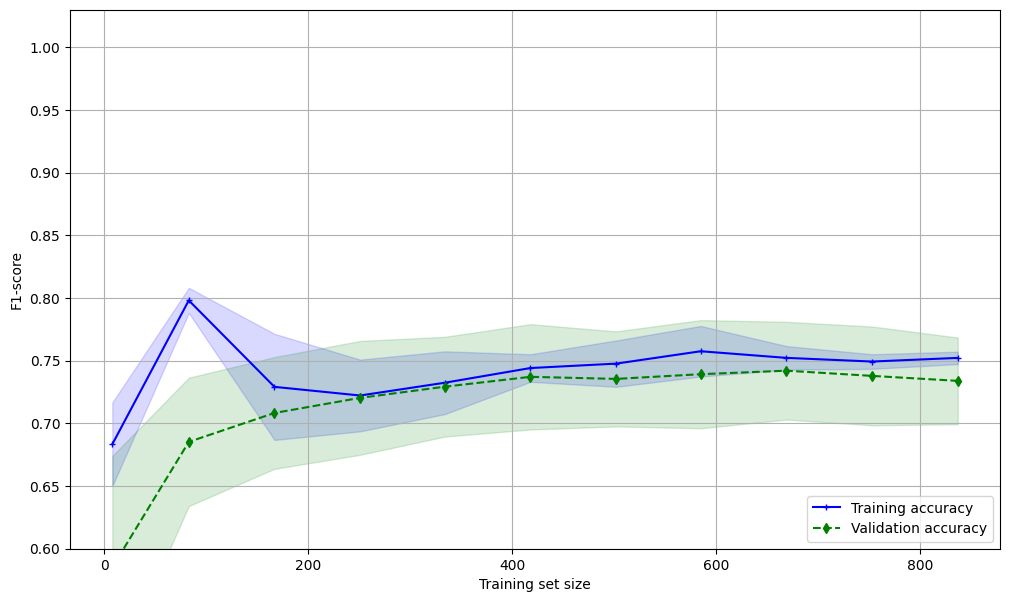

In [36]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])

In [37]:
range_C = [0.001,0.01,0.1,1,10,100]
train_scores, test_scores = validation_curve(cls,
        X=X_train, 
        y=y_train, 
        param_range=
        range_C, 
        param_name='classifier__C',
        cv=5, 
        n_jobs=-1, 
        scoring='f1'
)

(0.05, 100)

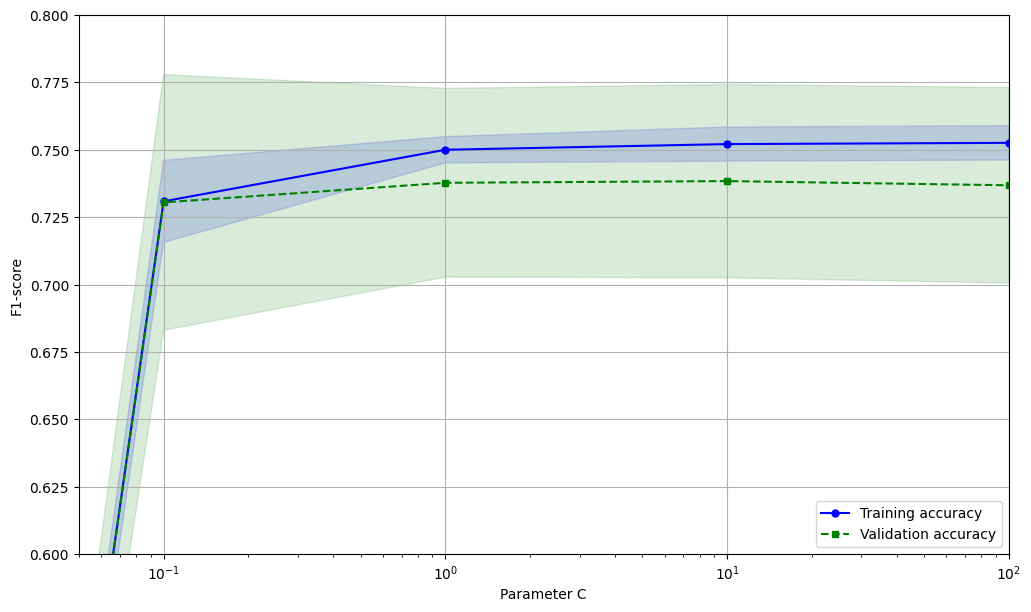

In [38]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()
ax.plot(range_C, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

ax.fill_between(range_C,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(range_C, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

ax.fill_between(range_C,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Parameter C')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.6, 0.8])
ax.set_xscale('log')
ax.set_xlim([0.05,100])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=50a627b9-7e19-4f25-8fa0-594b74e0bcbc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>